# Homework 2

### House Prices: Advanced Regression Techniques (Kaggle Competition)

#### By: Spencer Wise

If you ask a home buyer to describe their dream house, they'll probably list the number of bedrooms and bathrooms they're looking for and maybe an approximate size in square feet. They may even describe the style of home whether it be a cape cod style, modern, or ranch style. Do they how much each of these features contributes to the price of the home? Probably not, but that's exactly what we're going to try and figure out through machine learning!

The goal of this Kaggle competition and assignment is to create models that predict house prices. The training dataset contains 1460 observations and 80 features. The test dataset has 1459 observations and 79 features. To begin, let's start by importing the necessary packages and reading in the data.

### Module Imports

In [1]:
# Pandas for data loading, manipulation etc.
import pandas as pd

# Numeric functions
import numpy as np
from scipy import stats
from scipy.stats import norm

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning packages for modeling 
from sklearn.linear_model import SGDRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Other Packages
import warnings
warnings.filterwarnings('ignore')

### Load Data

Here we are going to first load the training and test datasets into pandas dataframes.

In [2]:
# Loading datasets into separate pandas dataframes
train = pd.read_csv(r"C:\Users\Spencer\Dropbox\School\Fall 2018\Machine Learning\Projects\Homework_2\train.csv", encoding="latin1")
test = pd.read_csv(r"C:\Users\Spencer\Dropbox\School\Fall 2018\Machine Learning\Projects\Homework_2\test.csv", encoding="latin1")

In [3]:
# Print the shape of the test and training datasets
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


One interesting thing to note right off the bat is that the training dataset has one more column than the test dataset. that is because the train dataset includes our target value (aka SalePrice). Let's take a closer look by previewing our training data. 

In [4]:
# Preview the data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Analyze the Target

The first thing that we want to do is identify and analyze the target. In this case, our target is "SalePrice" as it is the variable that we will be trying to predict. 

In [5]:
# Descriptive summary of SalePrice data
target = train['SalePrice']
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Next we will want to take a look at the distribution of the SalePrice data and a probability plot to test for normality.

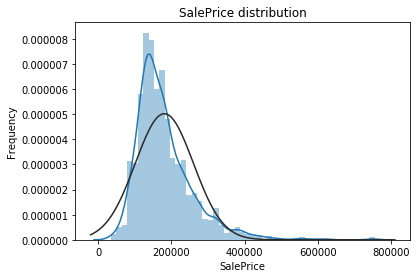

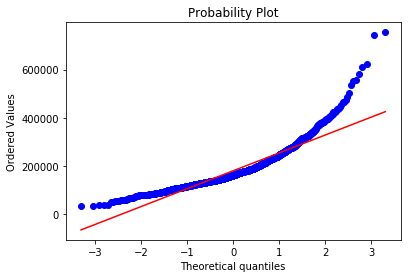

In [6]:
# Create a histogram and normal probablity plotof the SalePrice data
sns.distplot(target, fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(target, plot=plt)

We can see from the above histogram that the target variable is not normal. It is right skewed and does not follow the diagonal line on the probability plot. Because we know that linear models prefer normally distributed data, we will apply a transformation to our target variable in order to make it more normally distributed. In cases of positive skewness, log transformations usually work well so we will perform a log-transformation of the target variable.

In [7]:
# Applying a log transformation of the SalePrice data
target = np.log(target)

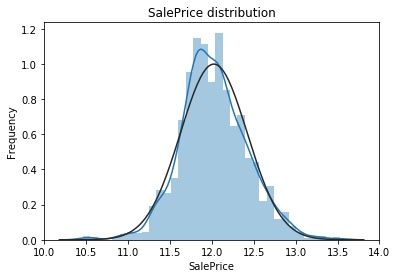

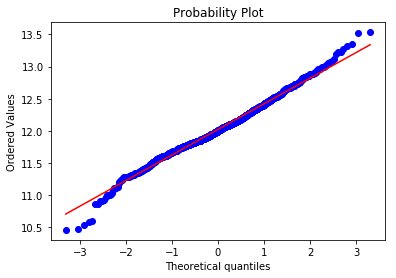

In [8]:
# Transformed histogram and normal probability plot
sns.distplot(target, fit=norm);
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(target, plot=plt)

The skew now seems to be corrected and the data appears to be more normally distributed. 

## Learn the Data

Now that we've corrected our target variable, we'll want to learn as much as we can about the data. The things that we will focus on are:
- Knowing all the variables in the dataset
- Knowing what is correlated
- Knowing if there are missing variables 

In [9]:
# List all of the variables in the dataset
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

As we can see above, we have 80 variables in the dataset. We basically have information about every aspect of a home and its surrounding property. These include common things like the number of bedrooms and bathrooms and squarefootage as well as more obscure metrics like the slope of the property and height of the basement. 

The variables are :

- SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
- MSSubClass: The building class
- MSZoning: The general zoning classification
- LotFrontage: Linear feet of street connected to property
- LotArea: Lot size in square feet
- Street: Type of road access
- Alley: Type of alley access
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- LandSlope: Slope of property
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to main road or railroad
- Condition2: Proximity to main road or railroad (if a second is present)
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Overall material and finish quality
- OverallCond: Overall condition rating
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- ExterQual: Exterior material quality
- ExterCond: Present condition of the material on the exterior
- Foundation: Type of foundation
- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Number of bedrooms above basement level
- Kitchen: Number of kitchens
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Functional: Home functionality rating
- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition
- PavedDrive: Paved driveway
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- PoolQC: Pool quality
- Fence: Fence quality
- MiscFeature: Miscellaneous feature not covered in other categories
- MiscVal: Dollar Value of miscellaneous feature
- MoSold: Month Sold
- YrSold: Year Sold
- SaleType: Type of sale
- SaleCondition: Condition of sale

Now that we have a better idea of what our variables are and what they represent, the next we'll want to do is get an idea of any correlation in the data. The first way we will do this is by creating a heatmap of all of the numeric variables. 

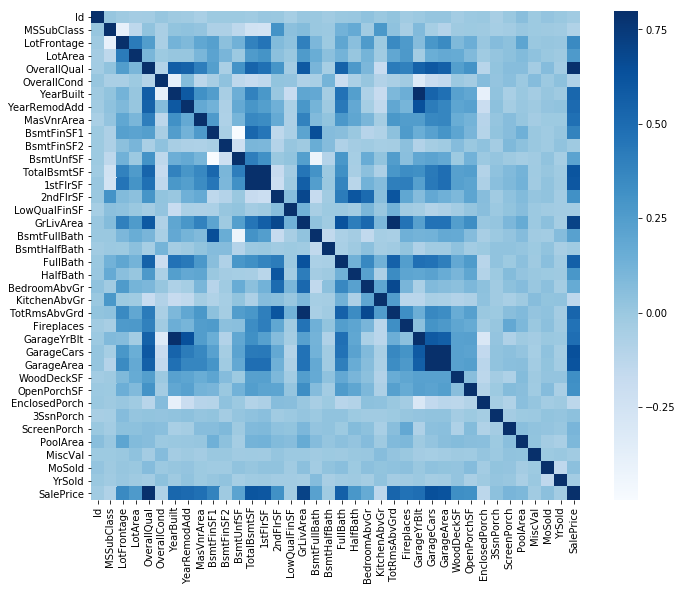

In [10]:
# Create a correlation matrix or heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="Blues");

The heatmap is a great way to quickly identify relationships between our variables. 

The first correlations that we will want to pay particular attention to are the 'SalePrice' correlations. 'OverallQal', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageCars', and 'GarageArea' all are dark blue and appear to have highly positive correlation with 'SalePrice'.  

There are a few other dark blue squares that stand out for example 'GarageYrBlt' and 'YearBuilt' and 'TotalBsmtSF' and '1stFlrSF' which may represent multicollinearity. 

For now, we will focus on the 'SalePrice' correlations. Let's take a closer look at these correlations by creating a target correlations heatmap

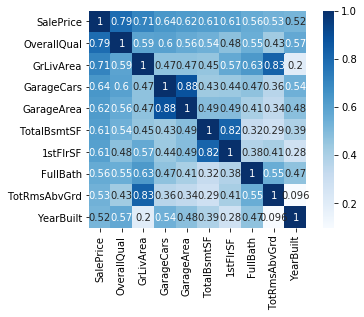

In [11]:
# Target variable heatmap
n = 10
cols = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index
corrm = np.corrcoef(train[cols].values.T)
hm = sns.heatmap(corrm, cbar=True, annot=True, square=True, yticklabels=cols.values, xticklabels=cols.values, cmap="Blues")
plt.show()

Now we're zoomed in and able to look at the 10 variables most correlated with 'SalePrice'. Upon closer look a few of these variables appear to be very similar:

- GarageCars and GarageArea seem to be correlated about the same and I would assume that is because the number of cars that fit in a garage is also determined by the size of the garage area. They will essentially act as one. As a result, we'll only need one of these variables. We'll keep GarageCars as it is slightly higher. 
- TotalBsmtSF and 1stFlrSF also appear to be closely correlated (it makes sense in my head as the basement will most likely be the same size and shape as the floor above it for the most part). We'll keep TotalBsmtSF since it has the higher correlation.
- YearBuilt and YearRemodAdd also seem to have the same problem. Again we'll keep YearBuilt as it has a higher correlation.

Everything else seems to be ok so to summarize, the variables we believe to have the highest positive correlation with SalePrice (with the exception of some variables that suffer from multicollinearity) are:
- OverallQual
- GrLivArea
- GarageCars
- TotalBsmtSF
- FullBath
- YearBuilt


Now let's create some scatter plots between 'SalePrice' and these highly correlated variables.

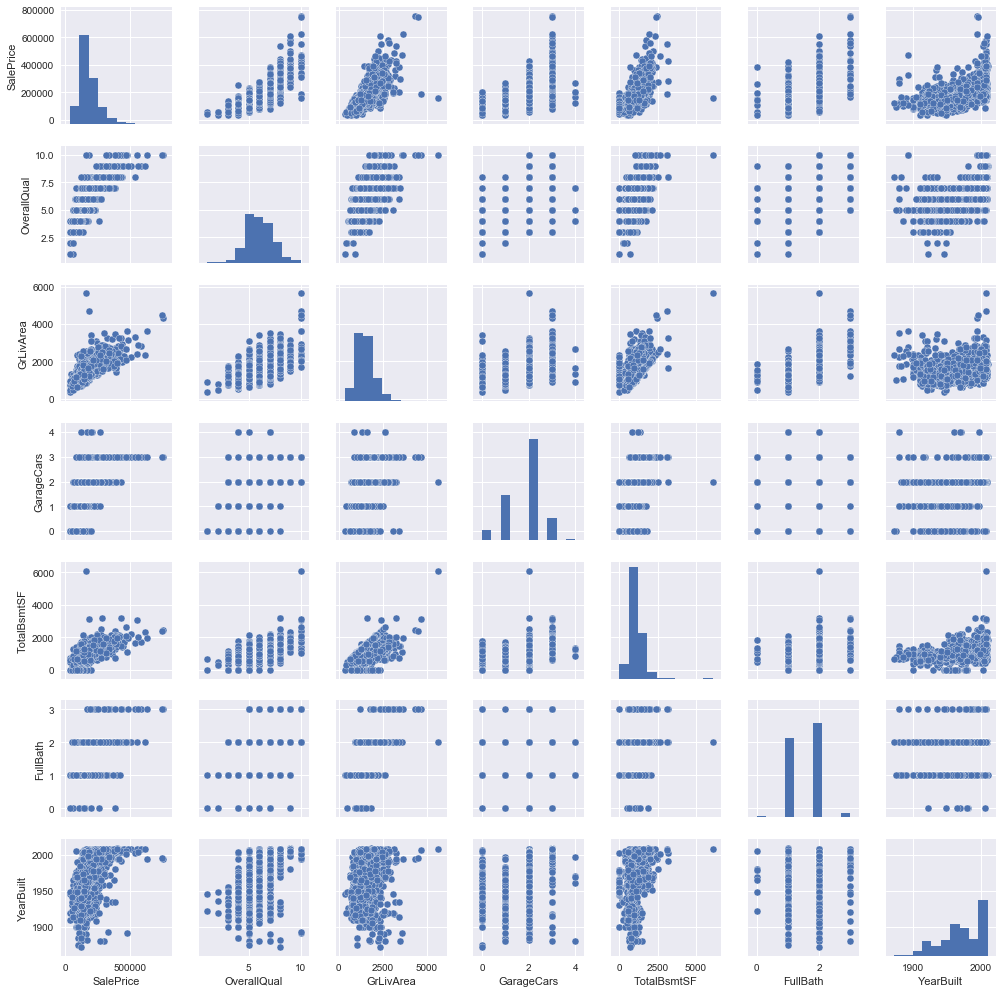

In [12]:
# Use pairplot to see the bivariate relationship between each pair of features
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size= 2, kind='scatter')
plt.show();

In the above scatterplots, we gain quite a bit of insight. Some of the highlights are the SalePrice / GrLivArea plot which shows a fairly linear relationship. We see a fairly similar shape when we look at the SalePrice / TotalBsmtSF graph as well, which is to be expected. OverallQual also shows a very strong correlation with an almost exponential shape. 

## Clean the Data

Now that we've learned more about our data, it is time to clean it. Our goal in cleaning the data is to apply the necessary transformations to our data before feeding it to our algorithm.

The steps we will take for data cleaning are:
- Detect and correct missing values
- Remove outliers
- Create dummy variables

### Missing Data

We first want to figure out how much missing data we have, where they are located, and then determine whether they are missing randomly or non-randomly. 

This is important because we need to make sure that the missing data is not biased. The answer to this question is important because it will help us decide how to deal with the missing data. 

In [13]:
# Display columns with missing data (nan values)
cols_with_na = train.isnull().sum()
cols_with_na = cols_with_na[cols_with_na>0]
print(cols_with_na.sort_values(ascending=False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


Looking at the description above, we can determine that many of the Nan values are not true missing values, but rather an indication that the property does not have a specific feature. For example a property with a Nan in any of the Garage or Basement features has no garage or basement. 

This is valuable information as it absolutely affects the price of the home. The way I will correct this is by replacing the missing values with the string "None" for the categorical variables and with a zero for the numeric variables. 

In [14]:
# Columns where NaN values are important
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# Replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    train[col].fillna('None',inplace=True)
    
# GarageYrBlt NaNs means no garage. We will fill with property YearBuilt instead as it is more accurate than 0
train.loc[train.GarageYrBlt.isnull(),'GarageYrBlt'] = train.loc[train.GarageYrBlt.isnull(),'YearBuilt']

# No masonry veneer. Replace with 0
train.MasVnrArea.fillna(0,inplace=True)

# No basement. Replace with 0  
train.BsmtFullBath.fillna(0,inplace=True)
train.BsmtHalfBath.fillna(0,inplace=True)
train.BsmtFinSF1.fillna(0,inplace=True)
train.BsmtFinSF2.fillna(0,inplace=True)
train.BsmtUnfSF.fillna(0,inplace=True)
train.TotalBsmtSF.fillna(0,inplace=True)

# No garage. Replace with 0
train.GarageArea.fillna(0,inplace=True)
train.GarageCars.fillna(0,inplace=True)

# Check to make sure we have successfully replaced our missing values
train[cols_fillna].head(5)

,PoolQC,MiscFeature,Alley,Fence,MasVnrType,FireplaceQu,GarageQual,GarageCond,GarageFinish,GarageType,BsmtExposure,BsmtCond,BsmtQual,BsmtFinType1,BsmtFinType2
0,None,None,None,None,BrkFace,None,TA,TA,RFn,Attchd,No,TA,Gd,GLQ,Unf
1,None,None,None,None,None,TA,TA,TA,RFn,Attchd,Gd,TA,Gd,ALQ,Unf
2,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Mn,TA,Gd,GLQ,Unf
3,None,None,None,None,None,Gd,TA,TA,Unf,Detchd,No,Gd,TA,ALQ,Unf
4,None,None,None,None,BrkFace,TA,TA,TA,RFn,Attchd,Av,TA,Gd,GLQ,Unf


The next step is to deal with the missing LotFrontage values. It's missing a decent amount of values. Lot Frontage is the only remaining numeric variable with missing values. We'll fill them in with the mean lot frontage. 

In [15]:
# Replacing NaN LotFrontage values with mean value
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage'].mean())

Now the remaining missing values are all found in categorical variables. To deal with these, we will replace them with the mode value. 

In [16]:
# Replacing NaN categorical variable values with the mode value
for variable in train:
   # Features with a 'dtype' of O are categorical 
    if train[variable].dtype == 'O':
       train[variable] = train[variable].fillna(train[variable].mode()[0])

Now let's double check to make sure we've corrected all of our missing values.

In [17]:
# Should return 'False' if we've corrected them all
train.isnull().any().any()

False

### Outliers

The next step on our journey to clean data is finding and removing any outliers.  To start, we'll separate our variables based on whether they are categorical or numerical. 

In [18]:
# Create two empty lists
numeric_variables = []
categorical_variables = []

# Seperate variables by dtype
for variable in train.columns:
    if train[variable].dtype == "object":
        categorical_variables.append(variable)
    else:
        numeric_variables.append(variable)
        
print("Number of Numerical Variables:", len(numeric_variables), "\nNumber of Categorical Variables:", len(categorical_variables))

Number of Numerical Variables: 38 
Number of Categorical Variables: 43


Now we will filter outliers by determining the z-score of each column relative to the column mean and standard deviation. Then we will remove rows that contain a numeric variable value greater than 5 standard deviations away from the standardized mean. 

In [19]:
# Filter outliers
n_std = 5
len(train) - len(train[train[numeric_variables].apply(lambda x: np.abs(x - x.mean()) / x.std() < n_std).all(axis=1)])

91

Using this rule, we will drop 91 rows of our training data. 

In [20]:
# Drop rows in training set (and target) according to the rule described above
train = train[train[numeric_variables].apply(lambda x: np.abs(x - x.mean()) / x.std() < 10).all(axis=1)]

Since we've dropped rows of data, we need to recreate our target array so as to not include those missing instances. 

In [21]:
# Recreat target array
target = train['SalePrice']
target = np.log(target)

Next, we need to drop our target variable and Id from the training dataset.

In [22]:
# Drop SalePrice and Id
train = train.drop(['SalePrice', 'Id'], axis = 1)

### Dummy Variables

Now that we have removed all of our outliers, we will move onto the final step in the data cleaning process which is to create dummy variables for our categorical variables

In [23]:
# Create train dummies
train = pd.get_dummies(train)
print(train.shape)

(1437, 295)


### Clean Test Data

Now I will perform all  of the data cleaning on the test data as well.

In [24]:
# Columns where NaN values are important
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2']

# Replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    test[col].fillna('None',inplace=True)
    
# GarageYrBlt NaNs means no garage. We will fill with property YearBuilt instead as it is more accurate than 0
test.loc[test.GarageYrBlt.isnull(),'GarageYrBlt'] = test.loc[test.GarageYrBlt.isnull(),'YearBuilt']

# No masonry veneer. Replace with 0
test.MasVnrArea.fillna(0,inplace=True)

# No basement. Replace with 0  
test.BsmtFullBath.fillna(0,inplace=True)
test.BsmtHalfBath.fillna(0,inplace=True)
test.BsmtFinSF1.fillna(0,inplace=True)
test.BsmtFinSF2.fillna(0,inplace=True)
test.BsmtUnfSF.fillna(0,inplace=True)
test.TotalBsmtSF.fillna(0,inplace=True)

# No garage. Replace with 0
test.GarageArea.fillna(0,inplace=True)
test.GarageCars.fillna(0,inplace=True)

# Replacing NaN LotFrontage values with mean value
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontage'].mean())

# Replacing NaN categorical variable values with the mode value
for variable in test:
   # Features with a 'dtype' of O are categorical 
    if test[variable].dtype == 'O':
       test[variable] = test[variable].fillna(test[variable].mode()[0])
    
# Should return 'False' if we've corrected them all
test.isnull().any().any()

False

In [25]:
# Create Test Dummies
test = pd.get_dummies(test)
print(test.shape)

# Only keep columns in test that are also found in train
train = train.reindex(columns = test.columns, fill_value=0)

(1459, 285)


### Model Fitting & Evaluation

Now that all of our data has been cleaned, the next step is to create models to predict our target variable of SalePrice. The goal is to use machine learning techniques to learn from our training data the relationship between a set of variables and our target variable (which we want to predict). 

In order to determine which of our models is the best, we need to decide on a metric that we will use to evaluate all of our models. A great metric to use to evaluate the predictive abilities of a model is mean squared error (MSE). What MSE does is it subtracts our predicted value from the actual and then we square the difference (since we don't care about the direction of the error). Then we take a mean of all these values. 

So, the first thing I will do is create a kind of baseline model from what we did in class. This will allow us to have something to compare our later more complicated models against. 

But first, time to scale the data!

In [26]:
# Scale the training dataset
scaler = StandardScaler()
scaler.fit(train)
scaled_train_df = scaler.transform(train)

# Scale the test dataset
scaler.fit(test)
scaled_test_df = scaler.transform(test)

# The training and test sets should have the same number of columns
print(target.shape, scaled_train_df.shape, scaled_test_df.shape)

(1437,) (1437, 285) (1459, 285)


#### Basic Linear Regression

The basic assumptions of all linear regression models are:
1. Linearity 
2. Multivariate normality
3. No (or little) multicollinearity
4. No auto-correlation
5. Homoskedasticity 

In [27]:
# Fit the model
basic_linear_regression_model = SGDRegressor(tol=.00001, eta0=.01)
basic_linear_regression_model.fit(scaled_train_df, target)

# Calculate the MSE
predictions = basic_linear_regression_model.predict(scaled_train_df)
mse = mean_squared_error(target, predictions)
print("MSE: {}".format(np.sqrt(mse)))

MSE: 31.420325859331253


Nice! We have our first model up and running! If we disect our model above, we will see that we passed a few parameters to SGDRegressor. These two parameters are telling it the initial learning rate and when we would like it to stop iterating. 

By simply adjusting these two parameters, we can significantly manipulate our MSE output.

#### Implementing a Train/Test Split into the Basic Linear Regression

Our next addition to our model will be a train/test split. Above, we fit the model using all of the training data. But word on the street is that by splitting the data into a training set and a test set, we can improve our results!

In addition to improving our Mean Squared Error output, the train/test split should also help to avoid any over-fitting of our data.  

In [28]:
# Splitting the data into two datasets (training and test)
X_train, X_test, y_train, y_test = train_test_split(scaled_train_df, target, test_size=0.20, random_state=42)

Now we can use our training dataset to train and then calculate the MSE for both our training and testing data set. 

In [29]:
# Fit the model
linear_regression_model = SGDRegressor(tol=.00001, eta0=.01)
linear_regression_model.fit(X_train, y_train)

# Predit target values for the training and test datasets
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

# Calculate the MSE for the training and test datasets
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

#Print MSEs
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 3107.962979245836
Test MSE: 60.679300062566575


We now have our MSE for both our training and testing data. One thing we can notice right off the bat is that the gap between the two is relatively large. This could suggest an overfitting problem. 

Next we will add cross validation to our Basic Linear Regression Model to see if that will help us improve as well.

#### Adding Cross Validation to our Linear Regression Model

With cross validation, we further split our data into training sets and validation sets. This allows us to test a whole bunch of hyper parameters to see which ones perform the best on our training data. We then take the model that performs the best on the validation set and see how it does against the testing set.

In [30]:
# Give a list of parameters for cross validation
param_dist = {"eta0": [ .001, .002, .01, .04, .1, .2, 1, 5], "tol": [.000001, .00001, .0001, .001, .01, .1]}
n_iter_search = 8

# Cross validation and fit the model
cross_linear_regression_model = SGDRegressor()
cross_random_search = RandomizedSearchCV(cross_linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
cross_random_search.fit(X_train, y_train)

#Print best parameters and negative MSE
print("Best Parameters: {}".format(cross_random_search.best_params_))
print("Best Negative MSE: {}".format(cross_random_search.best_score_))

Best Parameters: {'tol': 0.0001, 'eta0': 0.001}
Best Negative MSE: -2.945161266222839


Our cross validation has done a whole lot for us here! First, it's telling us which parameters performed the best which were, in this case, a tolerance of 0.01 and a learning rate of 0.002. It has also improved our negative MSE significantly. This is great news, we're on the right track and moving in the right direction!

Now that we've implemented the train/test split and cross validation, let's try our hand at regularization.

### Regularized Linear Models

Regularization is a method that is used to penalize a model for learning complet relationship or form large coefficients. This is yet another way we can avoid the problem of over-fitting. 

There are three different regularized linear models we'll try to see which one performs the best. These three models are:
- Lasso: Modifies the cost function by adding the sum of the absolute values of the coefficients.
- Ridge: Modifies the cost function by adding the sum of the squared values of the coefficients.
- Elastic-Net: Add both and choose how to weight them. 

Each of these three regularization methods takes a weighting factor (alpha) that tells you how much you should weight the regularization term. An alpha of zero would add zero penalty. A high alpha would penalize the model significantly for ahving large coefficients. We will use cross validation to figure out the best alpha value. 

#### Lasso (L1)

In [31]:
# Cross Validation
lasso = linear_model.Lasso()
lasso_gridsearch = GridSearchCV(lasso, {"alpha": [.1, .3, .5, .7, .9]})
# Fit the Model
lasso_gridsearch.fit(X_train, y_train)
# Make Predictions
train_predictions = lasso_gridsearch.predict(X_train)
test_predictions = lasso_gridsearch.predict(X_test)
# Print the best parameters and the MSE
print("Lasso:")
print("Best Parameters: {}".format(lasso_gridsearch.best_params_))
print("Train MSE: {:.20f}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {:.20f}".format(mean_squared_error(y_test, test_predictions)))

Lasso:
Best Parameters: {'alpha': 0.1}
Train MSE: 0.04457342487775660389
Test MSE: 0.03977274445456123464


#### Ridge (L2)

In [32]:
# Cross Validation
ridge = linear_model.Ridge()
ridge_gridsearch = GridSearchCV(ridge, {"alpha": [.1, .3, .5, .7, .9]})
# Fit the Model
ridge_gridsearch.fit(X_train, y_train)
# Make Predictions
train_predictions = ridge_gridsearch.predict(X_train)
test_predictions = ridge_gridsearch.predict(X_test)
# Print the best parameters and the MSE
print("Ridge:")
print("Best Parameters: {}".format(ridge_gridsearch.best_params_))
print("Train MSE: {:.20f}".format(mean_squared_error(y_train, train_predictions)).format())
print("Test MSE: {:.20f}".format(mean_squared_error(y_test, test_predictions)))

Ridge:
Best Parameters: {'alpha': 0.9}
Train MSE: 0.00879590376475227441
Test MSE: 0.01182940298796860031


#### Elastic Net

In [33]:
# The values for 'l1_ratio' were the values recommended in the scikit-learn docs
clf_en = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
# Fit the Model
clf_en.fit(X_train, y_train)
# Make Predictions
train_predictions = clf_en.predict(X_train)
test_predictions = clf_en.predict(X_test)
# Print the MSE
print("Elastic Net:")
print("Train MSE: {:.20f}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {:.20f}".format(mean_squared_error(y_test, test_predictions)))

Elastic Net:
Train MSE: 0.01332990622564092682
Test MSE: 0.01270345754167370375


Nice! Our regularized models have made a huge difference. Now if we compare the results of the three models, it appears that the ridge model narrowly beats the elastic net model in terms of the test MSE. That being said, there is a relatively large gap between the Ridge models train MSE and test MSE. This may represent some overfitting. Since our elastic net model was only slightly worse in terms of test MSE and has a train MSE that is almost identical, I think I would be more confident in its predictive ability.

Let's try one more model just to see how it fairs. This model will be a K-Nearest Neighbor model.

#### K-Nearest Neighbors

K-Nearest Neighbors is a relatively simple model that is easy to understand. Although it is more commonly used in classification problems, it can also be used for regression tasks which is what we will be doing here. 

The basic assumption of this model is that data points that are close are similar for our target variable.

The algorithm works by first defining k which is the number of neighbors. Then you define the distance metric (usually Euclidean distance). Finally, for each new data point, we will find the k nearest training points and combine their classes by voting to determine the predicted class. 

The best part about this model is that it is easy to understand and that it doesn't require traditional training. On the other hand, we will need to define k and the distance metrics (although we can fine tune these with cross validation) and it's difficult to determine which features are most important from this model. Nevertheless, we're gonna give it a go here!

In [36]:
# Cross validation for k and distance metric
reg = KNeighborsRegressor()
neigh_gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
# Fit the model
neigh_gridsearch.fit(X_train, y_train)
# Print best parameters and train and test MSE
print("Best Params: {}".format(neigh_gridsearch.best_params_))
y_pred_train = neigh_gridsearch.predict(X_train)
y_pred_test = neigh_gridsearch.predict(X_test)
print("Train MSE: {:.20f}\tTest MSE: {:.20f}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Train MSE: 0.00000000000000000000	Test MSE: 0.02821308196972111687


As we can see above, the train MSE is 0 which probably means that this model over-fit our data. It's all good because the test MSE wasn't as good as our regularized models anyway!

### Conclusion & Kaggle Submission

Now we've tested 7 different models with many different hyper parameters in order to find our best performing model. Though it was close, the Ridge model narrowly beat out the elastic net model with an MSE of 0.0118 compared to Elastic Net's 0.0127.  But as I mentioned above, the Ridge model may be overfitting the data, and, as a result, I am more confident in the predictive capabilities of the elastic net model. 

To end this assignment, I will export my models as CSV files to submit to Kaggle and see how they do. 

My most recent Kaggle submission of my elastic net model ranked 2081 out of 4092 participants with a log MSE of 0.13615. 

In [37]:
# Export predictions from each of the models
models = ['cross_random_search', 'lasso_gridsearch', 'ridge_gridsearch', 'clf_en', 
          'neigh_gridsearch']
test_submission = pd.read_csv(r"C:\Users\Spencer\Dropbox\School\Fall 2018\Machine Learning\Projects\Homework_2\test.csv", encoding="latin1")

In [39]:
# Cross Random Search Linear Regression Model
y_pred = np.exp(cross_random_search.predict(scaled_test_df))
submission_cross_random_search = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_cross_random_search.to_csv('submission_model_1.csv', sep=',')

# Lasso Model
y_pred = np.exp(lasso_gridsearch.predict(scaled_test_df))
submission_lasso_gridsearch = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_lasso_gridsearch.to_csv('submission_model_2.csv', sep=',')

# Ridge Model
y_pred = np.exp(lasso_gridsearch.predict(scaled_test_df))
submission_lasso_gridsearch = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_lasso_gridsearch.to_csv('submission_model_3.csv', sep=',')

# Elastic Net Model
y_pred = np.exp(clf_en.predict(scaled_test_df))
submission_clf_en = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_clf_en.to_csv('submission_model_4.csv', sep=',')

# K-Nearest Neighbor Model
y_pred = np.exp(neigh_gridsearch.predict(scaled_test_df))
submission_neigh_gridsearch = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_neigh_gridsearch.to_csv('submission_model_5.csv', sep=',')

Sources:
- [Tyler's Lecture on Modeling](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_4_Linear_Regression_and_Evaluation.ipynb)
- [Tyler's Lecture on K-Nearest Neighbors](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_6_K_Nearest_Neighbors.ipynb)
- [Detecting outliers thread from Stack Overflow](https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe)
- [Helful kernel for analyzing the target](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)